In [18]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv(r"C:\Users\jj_jo\Documents\Customer churn project.csv")
df

,Call Failure,Complaints,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Age Group,Tariff Plan,Status,Age,Customer Value,Churn
0,8,0,38,0,4370,71,5,17,3,1,1,30,197.640,0
1,0,0,39,0,318,5,7,4,2,1,2,25,46.035,0
2,10,0,37,0,2453,60,359,24,3,1,1,30,1536.520,0
3,10,0,38,0,4198,66,1,35,1,1,1,15,240.020,0
4,3,0,38,0,2393,58,2,33,1,1,1,15,145.805,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3145,21,0,19,2,6697,147,92,44,2,2,1,25,721.980,0
3146,17,0,17,1,9237,177,80,42,5,1,1,55,261.210,0
3147,13,0,18,4,3157,51,38,21,3,1,1,30,280.320,0
3148,7,0,11,2,4695,46,222,12,3,1,1,30,1077.640,0


In [19]:
# which age groups send more sms than phone calls
frequency_of_use = df.groupby("Age Group").agg({"Frequency of SMS": "mean", "Frequency of use": "mean"})
frequency_of_use.columns = ["Average SMS", "Average calls"]
frequency_of_use = frequency_of_use.sort_values(by = "Average SMS", ascending = False).reset_index()
frequency_of_use

# Age Group 3 and 2 Sends more SMS than calls on average

,Age Group,Average SMS,Average calls
0,3,90.042807,68.442807
1,2,75.499518,72.075217
2,4,42.053165,60.562025
3,5,28.247059,77.523529
4,1,20.195122,76.642276


In [20]:
# create pivot table for clearer visualisation of data
freq_of_use_pivot_table = pd.pivot_table(frequency_of_use, index = "Age Group", values = ["Average SMS", "Average calls"])
freq_of_use_pivot_table = freq_of_use_pivot_table.sort_values(by = "Average SMS", ascending = False)
freq_of_use_pivot_table

,Average SMS,Average calls
Age Group,,
3,90.042807,68.442807
2,75.499518,72.075217
4,42.053165,60.562025
5,28.247059,77.523529
1,20.195122,76.642276


In [21]:
# Use groupby and aggregation to find out the min and max age of each group. This is the age range
age_group_age = df.groupby("Age Group").agg({"Age": ["min", "max"]})
age_group_age.columns = ["min age", "max age"]
age_group_age.reset_index()


# From above we discovered that Age groups 3 and 2 send more SMS than calls on average. This age range is between 30-45.
# People in this age range 30-45 send more SMS than calls

,Age Group,min age,max age
0,1,15,15
1,2,25,25
2,3,30,30
3,4,45,45
4,5,55,55


In [22]:
# What's the correlation betwen length of phone calls and different tariff plans
tariff_plan_data = df.groupby("Tariff Plan").agg({"Seconds of Use": "mean"})
tariff_plan_data = tariff_plan_data.reset_index()
tariff_plan_data

# We can see that people are on the phone for longer when on Tariff plan 2 compared to plan 1

,Tariff Plan,Seconds of Use
0,1,4309.620998
1,2,6403.261224


In [23]:
# convert seconds to minutes for clearer visualisation
# People on plan 2 are on the phone longer by 30 minutes
# 30 minutes seems like a significant difference?
tariff_plan_data["Minutes"] = pd.to_datetime(tariff_plan_data["Seconds of Use"], unit = "s").dt.strftime("%H:%M:%S")
tariff_plan_data

,Tariff Plan,Seconds of Use,Minutes
0,1,4309.620998,01:11:49
1,2,6403.261224,01:46:43


In [24]:
# find out correlation between charge amount and tariff plans
distinct_calls = df.groupby("Tariff Plan").agg({"Distinct Called Numbers": "mean"})
distinct_calls.columns = ["Num of Average Distinct calls"]
distinct_calls.reset_index()

# People on Tariff plan 2 also make more distinct calls on average

,Tariff Plan,Num of Average Distinct calls
0,1,22.649570
1,2,33.710204


In [25]:
# Merge distinct calls df to tariff plan data

pd.merge(left = tariff_plan_data,
        right = distinct_calls,
        left_on = "Tariff Plan",
        right_on = "Tariff Plan",
        how = "outer")

# There's a positive correlation between people on plan 2 and making longer phone calls and more distinct calls
# May indicate that people use plan 2 for a reason? To make these longer unique calls

,Tariff Plan,Seconds of Use,Minutes,Num of Average Distinct calls
0,1,4309.620998,01:11:49,22.649570
1,2,6403.261224,01:46:43,33.710204


In [26]:
# differenciate phone call length by short, medium, long calls
distinct_calls_age = pd.pivot_table(df, index = "Age Group", values = ["Distinct Called Numbers", "Seconds of Use"])
distinct_calls_age = distinct_calls_age.reset_index()
distinct_calls_age 

,Age Group,Distinct Called Numbers,Seconds of Use
0,1,34.325203,3986.853659
1,2,22.985535,4536.344262
2,3,21.502456,4463.154386
3,4,26.086076,4042.088608
4,5,29.723529,5512.094118


In [27]:
# find standard deviation for total seconds on call
# set short, medium, long calls around the standard deviation of the Seconds of Use

standard_deviation = distinct_calls_age["Seconds of Use"].std()
mean = distinct_calls_age["Seconds of Use"].mean()

def call_length(row):
    if row["Seconds of Use"] < (mean - standard_deviation):
        return "Short call"
    
    elif (mean - standard_deviation) <= row["Seconds of Use"] <= (mean + standard_deviation):
        return "Medium call"
    
    elif row["Seconds of Use"] > (mean + standard_deviation):
        return "Long call"
    

distinct_calls_age["Call Length"] = distinct_calls_age.apply(call_length, axis = 1)
distinct_calls_age

,Age Group,Distinct Called Numbers,Seconds of Use,Call Length
0,1,34.325203,3986.853659,Medium call
1,2,22.985535,4536.344262,Medium call
2,3,21.502456,4463.154386,Medium call
3,4,26.086076,4042.088608,Medium call
4,5,29.723529,5512.094118,Long call


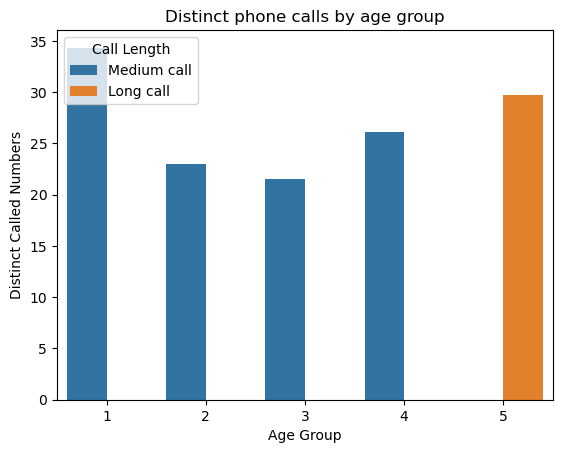

In [28]:
import seaborn as sns
# Create a plot visualizing the number of distinct phone calls by age group. 
#Within the chart, differentiate between short, medium, and long calls (by the number of seconds).

sns.barplot(x = "Age Group", y = "Distinct Called Numbers", hue = "Call Length", data = distinct_calls_age)

plt.title("Distinct phone calls by age group")
plt.show()

In [29]:
# Predict probability of whether customers will Churn and what factors increase lilikhood
call_failures_data = df.groupby("Churn").agg({"Call Failure": "mean"})
call_failures_data.columns = ["Average num of Call Failures"]
call_failures_data.reset_index()

# Shows the average number of people who Churn actualy experience less call failures on average. 
# Can't say Call failures play a role in Churning at the moment


,Churn,Average num of Call Failures
0,0,7.656121
1,1,7.476768


In [31]:
# Compare the number of complaints with the liklihood of Churning 

num_of_complaints = df.groupby("Churn").agg({"Complaints": "count"})
num_of_complaints.columns = ["num of complaints"]
num_of_complaints.reset_index()

# There is no positive correlation between the number of complaints aabd Churn rate
# It shows that people are leaving even without complaining -


,Churn,num of complaints
0,0,2655
1,1,495


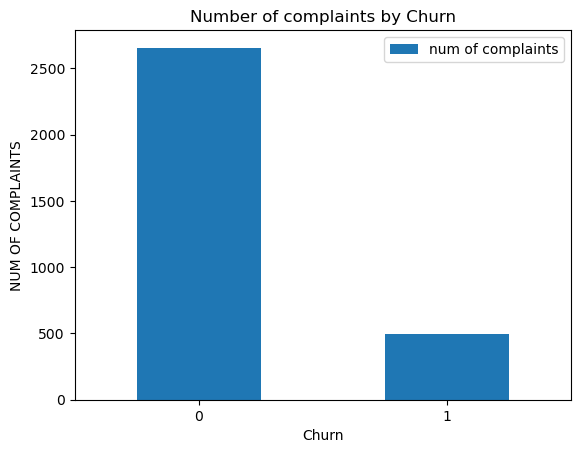

In [32]:
# plot bar chart for better visualisation
bar_chart = num_of_complaints.reset_index()
bar_chart = bar_chart.plot.bar(x = "Churn", y = "num of complaints", rot = 0, ylabel = "NUM OF COMPLAINTS", title = "Number of complaints by Churn")
plt.show()

In [33]:
# Calculate total complaints to compute percentage of complaints 
num_of_complaints["total complaints"] = num_of_complaints["num of complaints"].sum()
num_of_complaints = num_of_complaints[["num of complaints", "total complaints"]]
num_of_complaints.reset_index()

,Churn,num of complaints,total complaints
0,0,2655,3150
1,1,495,3150


In [34]:
# Caclculating the percentage of complaints 
num_of_complaints["complaint percentage"] = num_of_complaints["num of complaints"] / num_of_complaints["total complaints"] * 100
num_of_complaints = num_of_complaints[["num of complaints","total complaints", "complaint percentage"]]
num_of_complaints.reset_index()

# Shows that people who don't Churn make up 84% of total complaints
# As a result, cannot say the num of complaints have an impact on people Churning


,Churn,num of complaints,total complaints,complaint percentage
0,0,2655,3150,84.285714
1,1,495,3150,15.714286


In [35]:
# merge num_of_complaints and call_failures_data
merged_data = pd.merge(left = call_failures_data,
        right = num_of_complaints,
        left_on = "Churn",
        right_on = "Churn",
        how = "outer")

merged_data.reset_index()

,Churn,Average num of Call Failures,num of complaints,total complaints,complaint percentage
0,0,7.656121,2655,3150,84.285714
1,1,7.476768,495,3150,15.714286


In [36]:
# find out correlation between age and churning
# which age group is most likely to churn
# find out which age group is most common in this sample
# then correlate that with the use of SMS and frequency of phone calls

num_age_group = df.groupby("Age Group").agg({"Age Group": "count"})
num_age_group.columns = ["total"]
num_age_group.sort_values(by = "total", ascending = False).reset_index()

# This shows that the majority of the customer base is in age group 3 and 2

,Age Group,total
0,3,1425
1,2,1037
2,4,395
3,5,170
4,1,123


In [37]:
# merge num_age_group and frequency_of_use df

age_group_and_data = pd.merge(left = num_age_group,
        right = frequency_of_use,
        left_on = "Age Group",
        right_on = "Age Group",
        how = "outer")

col_name = {"total": "Total Num of People in This Age Group"}
age_group_data = age_group_and_data.rename(mapper = col_name, axis = 1)
age_group_data.sort_values(by = "Average SMS", ascending = False).reset_index(drop = True)

# This shows the majority of customer base is in age group 3 and 2; both of which prefer to send SMS over making phone calls

,Age Group,Total Num of People in This Age Group,Average SMS,Average calls
0,3,1425,90.042807,68.442807
1,2,1037,75.499518,72.075217
2,4,395,42.053165,60.562025
3,5,170,28.247059,77.523529
4,1,123,20.195122,76.642276


In [38]:
average_churn_age = df.groupby("Churn").agg({"Age": "mean"})
average_churn_age.reset_index()

# shows the average age of people who churn are in their 30's

,Churn,Age
0,0,31.065913
1,1,30.636364


In [39]:
merge_age = pd.merge(left = age_group_data,
        right = age_group_age,
        left_on = "Age Group",
        right_on = "Age Group",
        how = "outer")

merge_age.sort_values(by = "Total Num of People in This Age Group", ascending = False )



,Age Group,Total Num of People in This Age Group,Average SMS,Average calls,min age,max age
2,3,1425,90.042807,68.442807,30,30
1,2,1037,75.499518,72.075217,25,25
3,4,395,42.053165,60.562025,45,45
4,5,170,28.247059,77.523529,55,55
0,1,123,20.195122,76.642276,15,15


In [ ]:
# Overall Conclusion:

# Majority of people in age group 3. 
# Average age of people who churn are in their 30's which is age group 3
# Only conclusion that can be drawn is that there may be a correltion betweeen age and SMS usage
# People in age group 3 use SMS more than making phone calls
# Perhaps those who Churn aim to look for different plans regarding SMS usage - but this is just a wild assumption
# Overall there is no concrete evidence to show Age has an impact on Churning
# There is no positive correlation between the number of complaints and Churn rate
# It shows that people are leaving even without complaining 
# People who don't Churn make up 84% of total complaints
# As a result, cannot say the num of complaints have an impact on people Churning
# The average number of people who Churn actualy experience less call failures on average. 
# Can't say Call failures play a role in Churning at the moment

# With this info = can't predict whether a customer will Churn